In [4]:
import time
import requests
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Fix for module imports if notebook is in root
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Import your custom classes
from tester.TodoTester import TodoTester
from tester.ProjectTester import ProjectTester

# Configuration
API_URL = "http://localhost:4567"
LOAD_LEVELS = [10, 100, 500, 1000]

print("Imports complete. Configuration loaded.")

Imports complete. Configuration loaded.


In [5]:
try:
    requests.get(f"{API_URL}/todos", timeout=2)
    print(f"✅ Target API is online at {API_URL}")
except requests.RequestException:
    print(f"❌ Error: Could not connect to {API_URL}")
    print("   Please ensure the Part A server is running.")
    # Stop execution if server is down
    raise RuntimeError("Server not reachable")

✅ Target API is online at http://localhost:4567


In [6]:
# Instantiate testers
testers = [
    ("Todo", TodoTester(API_URL)),
    ("Project", ProjectTester(API_URL))
]

all_results = []

print("🚀 Starting Performance Tests...\n")

for name, tester in testers:
    print(f"--- Testing Object Type: {name} ---")
    
    for load in LOAD_LEVELS:
        # Run experiment
        result = tester.run_experiment(load)
        
        # Tag the result
        result['type'] = name 
        all_results.append(result)
        
        # Cool-down to ensure CPU baseline resets
        time.sleep(1)

print("\n✅ Experiments Completed.")

🚀 Starting Performance Tests...

--- Testing Object Type: Todo ---

--- Starting Experiment (todos): Load = 10 objects ---
Results for todos (10 objects):
  > Create Time: 0.0969s
  > Update Time: 0.0802s
  > Delete Time: 0.0602s
  > Get Time: 0.0069s
  > Avg CPU Use: 100.0%
  > Avg Free RAM: 4857.0 MB

--- Starting Experiment (todos): Load = 100 objects ---
Results for todos (100 objects):
  > Create Time: 0.6068s
  > Update Time: 0.4618s
  > Delete Time: 0.3334s
  > Get Time: 0.0038s
  > Avg CPU Use: 82.53%
  > Avg Free RAM: 4834.91 MB

--- Starting Experiment (todos): Load = 500 objects ---
Results for todos (500 objects):
  > Create Time: 2.1826s
  > Update Time: 1.8653s
  > Delete Time: 1.828s
  > Get Time: 0.0041s
  > Avg CPU Use: 83.95%
  > Avg Free RAM: 4797.29 MB

--- Starting Experiment (todos): Load = 1000 objects ---
Results for todos (1000 objects):
  > Create Time: 3.755s
  > Update Time: 3.8416s
  > Delete Time: 3.2497s
  > Get Time: 0.0035s
  > Avg CPU Use: 81.97%
  > A

In [7]:
# Convert results to a Pandas DataFrame
df = pd.DataFrame(all_results)

# Reorder columns for readability
cols = ['type', 'load_count', 'create_time_sec', 'update_time_sec', 'delete_time_sec', 
        'rel_cpu_increase', 'rel_mem_consumed_mb', 'avg_cpu_percent']
df = df[cols]

# Rename columns for the display
display_df = df.rename(columns={
    'type': 'Type',
    'load_count': 'Load',
    'create_time_sec': 'Create (s)',
    'update_time_sec': 'Update (s)',
    'delete_time_sec': 'Delete (s)',
    'rel_cpu_increase': 'CPU Delta (%)',
    'rel_mem_consumed_mb': 'Mem Used (MB)',
    'avg_cpu_percent': 'Abs CPU (%)'
})

# Display the table
display(display_df)

,Type,Load,Create (s),Update (s),Delete (s),CPU Delta (%),Mem Used (MB),Abs CPU (%)
0,Todo,10,0.0969,0.0802,0.0602,0.00,8.95,100.00
1,Todo,100,0.6068,0.4618,0.3334,3.63,21.38,82.53
2,Todo,500,2.1826,1.8653,1.8280,6.55,-23.00,83.95
3,Todo,1000,3.7550,3.8416,3.2497,0.00,82.06,81.97
4,Project,10,0.0350,0.0299,0.0310,0.00,0.73,0.00
5,Project,100,0.3407,0.3523,0.4448,8.54,14.41,75.74
6,Project,500,2.1250,1.9945,1.9801,12.47,65.92,85.37
7,Project,1000,3.8651,4.0121,3.4077,6.70,40.72,80.90


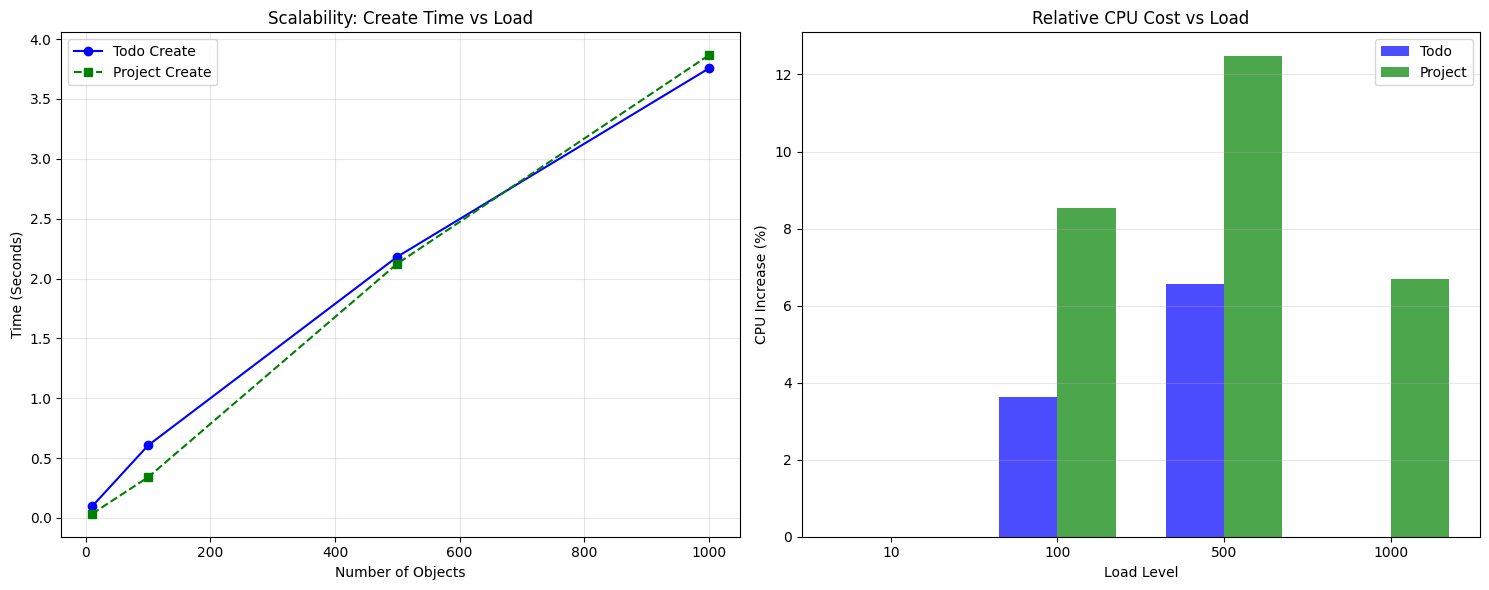

In [8]:
# Setup the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Filter data by type
todo_data = df[df['type'] == 'Todo']
proj_data = df[df['type'] == 'Project']

# --- Plot 1: Execution Time (Create Operation) ---
ax1.plot(todo_data['load_count'], todo_data['create_time_sec'], marker='o', label='Todo Create', color='blue')
ax1.plot(proj_data['load_count'], proj_data['create_time_sec'], marker='s', label='Project Create', color='green', linestyle='--')

ax1.set_title("Scalability: Create Time vs Load")
ax1.set_xlabel("Number of Objects")
ax1.set_ylabel("Time (Seconds)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- Plot 2: CPU Impact ---
width = 0.35
x = range(len(LOAD_LEVELS))

ax2.bar([i - width/2 for i in x], todo_data['rel_cpu_increase'], width, label='Todo', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], proj_data['rel_cpu_increase'], width, label='Project', color='green', alpha=0.7)

ax2.set_title("Relative CPU Cost vs Load")
ax2.set_xlabel("Load Level")
ax2.set_ylabel("CPU Increase (%)")
ax2.set_xticks(x)
ax2.set_xticklabels(LOAD_LEVELS)
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()